In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv("train.csv", parse_dates = ['booking_date','checkin_date','checkout_date'])
test = pd.read_csv("test.csv", parse_dates = ['booking_date','checkin_date','checkout_date'])
data_temp = pd.read_csv("train.csv", parse_dates = ['booking_date','checkin_date','checkout_date'])
test_temp = pd.read_csv("test.csv", parse_dates = ['booking_date','checkin_date','checkout_date'])

In [ ]:
data.head()

In [ ]:
def inspect_data(x):

    return pd.DataFrame({"Data Type":x.dtypes,"No of Levels":x.apply(lambda x: x.unique().shape[0],axis=0), "Levels":x.apply(lambda x: str(x.unique()),axis=0)})
inspect_data(data)

In [ ]:
#data.loc[data["season_holidayed_code"]==4.0]

In [ ]:
data.isnull().sum()

## Data Cleansing

In [ ]:
def date_cleaning(df):
    format_str = '%d/%m/%Y' # The format
    df['booking_date'] = df['booking_date'].apply(lambda x: dt.datetime.strftime(x, format_str))
    df['checkin_date'] = df['checkin_date'].apply(lambda x: dt.datetime.strftime(x, format_str))
    df['checkout_date'] = df['checkout_date'].apply(lambda x: dt.datetime.strftime(x, format_str))
    df['booking_date'] = pd.to_datetime(df['booking_date'])
    df['checkin_date'] = pd.to_datetime(df['checkin_date'])
    df['checkout_date'] = pd.to_datetime(df['checkout_date'])    
    df['D_checkin_month'] =  df.checkin_date.dt.month
    df['D_checkin_year'] =  df.checkin_date.dt.year
    df['D_checkin_week'] =  df.checkin_date.dt.week
    df['D_checkin_weekday'] =  df.checkin_date.dt.weekday
    df['D_booking_month'] =  df.booking_date.dt.month
    df['D_booking_year'] =  df.booking_date.dt.year
    df['D_booking_week'] =  df.booking_date.dt.week
    df['D_booking_weekday'] =  df.booking_date.dt.weekday
    df['checkin_date'] = np.where(df.D_checkin_year < 2015, df['checkin_date'] + pd.DateOffset(years=6), df['checkin_date'])
    df['checkout_date'] = np.where(df.D_checkin_year < 2015, df['checkout_date'] + pd.DateOffset(years=6), df['checkout_date'])
    df['D_checkin_year'] =  df.checkin_date.dt.year
    df['D_no_days_prior_Advanced'] =  (df.checkin_date - df.booking_date).dt.days
    df['D_no_days_stay'] =  (df.checkout_date - df.checkin_date).dt.days
    
    return df

In [ ]:
data = date_cleaning(data)
test = date_cleaning(test)

In [ ]:
data.head()

### Dropping unnecessary columns

In [ ]:
data.drop(['reservation_id','checkout_date','state_code_residence','memberid','resort_id'], axis=1, inplace=True)

In [ ]:
test.drop(['reservation_id','checkout_date','state_code_residence','memberid','resort_id'], axis=1, inplace=True)

In [ ]:
data[data.D_no_days_prior_Advanced < 0]

In [ ]:
data.drop(data[data.D_no_days_prior_Advanced < 0].index, inplace=True)
#test.drop(test[test.D_no_days_prior_Advanced < 0].index, inplace=True)

In [ ]:
print(data.shape)
print(test.shape)

In [ ]:
# Dropping booking date and checkin date as information from them has been extracted
data.drop(['booking_date','checkin_date','reservationstatusid_code'], axis=1, inplace=True)
test.drop(['booking_date','checkin_date','reservationstatusid_code'], axis=1, inplace=True)

### Converting datatypes to appropriate ones

In [ ]:
data[['channel_code','main_product_code','persontravellingid','resort_region_code','resort_type_code','room_type_booked_code','state_code_resort','booking_type_code']] = data[['channel_code','main_product_code','persontravellingid','resort_region_code','resort_type_code','room_type_booked_code','state_code_resort','booking_type_code']].astype('object')

In [ ]:
data.dtypes

In [ ]:
test[['channel_code','main_product_code','persontravellingid','resort_region_code',
    'resort_type_code','room_type_booked_code','state_code_resort','booking_type_code']] = test[['channel_code','main_product_code','persontravellingid','resort_region_code',
    'resort_type_code','room_type_booked_code','state_code_resort','booking_type_code']].astype('object')

In [ ]:
print(test.shape)
print(data.shape)

In [ ]:
data["season_holidayed_code"] = data["season_holidayed_code"].astype('object')
test["season_holidayed_code"] = test["season_holidayed_code"].astype('object')

In [ ]:
data["season_holidayed_code"].value_counts()

In [ ]:
test.isnull().sum()

### Imputing missing values

In [ ]:
data["season_holidayed_code"].fillna(data["season_holidayed_code"].mode()[0], inplace=True)
test["season_holidayed_code"].fillna(test["season_holidayed_code"].mode()[0], inplace=True)

In [ ]:
data.isnull().sum()

In [ ]:
# Creating dummies
data = pd.get_dummies(data, drop_first= True)
test = pd.get_dummies(test, drop_first= True)

In [ ]:
print(data.shape)
print(test.shape)

## Train and Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train,test1 = train_test_split(data,test_size = 0.3, random_state = 100)

In [ ]:
# Decoupling target from train

y_train = train['amount_spent_per_room_night_scaled']
X_train = train.copy().drop('amount_spent_per_room_night_scaled', axis=1)
y_test = test1['amount_spent_per_room_night_scaled']
X_test = test1.copy().drop('amount_spent_per_room_night_scaled', axis=1)

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [ ]:
test.shape

## Linear Model

In [33]:
from sklearn.linear_model import LinearRegression

In [34]:
# Fitting the train and predicting on test
lr = LinearRegression()
model1 = lr.fit(X_train, y_train)

In [35]:
train_preds = model1.predict(X_train)

In [36]:
test_preds = model1.predict(X_test)

In [37]:
from sklearn.metrics import mean_squared_error

In [38]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [39]:
from math import sqrt
print(sqrt(mean_squared_error(y_train, train_preds)))
print( mean_absolute_percentage_error(y_train, train_preds))

1.00609059026
10.898853043677544


In [40]:
print(sqrt(mean_squared_error(y_test, test_preds)))
print(mean_absolute_percentage_error(y_test, test_preds))

1.00516440645
10.88931246432048


In [41]:
!pwd

/nfsroot/data/home/B57gpu10/Hackathon


In [42]:
prediction1 = pd.DataFrame({"reservation_id":test_temp['reservation_id'],"amount_spent_per_room_night_scaled":model1.predict(test)})

In [44]:
prediction1.to_csv("prediction1.csv", index=False)

## Neural Net Model

In [45]:
from keras.models import Sequential
from keras.layers import Dropout, Dense 
from keras.optimizers import Adam
from keras.regularizers import l2

Using TensorFlow backend.


In [46]:
BATCH_SIZE = 45
# EPOCHS = 100
EPOCHS = 50
INPUT_SHAPE = X_train.shape[1]
optimizer = Adam(lr=0.0001)

In [47]:
model = Sequential()
model.add(Dropout(0.1,input_shape=(INPUT_SHAPE,)))
model.add(Dense(10,input_shape=(INPUT_SHAPE,), activation='relu',kernel_regularizer=l2(l=0.005),kernel_initializer='uniform'))
model.add(Dropout(rate=0.4))
model.add(Dense(10,activation='relu',kernel_regularizer=l2(l=0.005),kernel_initializer='uniform'))
model.add(Dropout(rate=0.4))
model.add(Dense(10,activation='relu',kernel_regularizer=l2(0.005),kernel_initializer='uniform'))
model.add(Dropout(rate=0.4))
model.add(Dense(10,activation='relu',kernel_regularizer=l2(0.005),kernel_initializer='uniform'))
model.add(Dropout(rate=0.3))
model.add(Dense(1, activation='linear'))

In [105]:
#model = Sequential() # This initializes a sequential model to which we can keep adding layers.
#model.add(Dense(50, kernel_initializer='uniform', 
 #               input_dim = 68, activation='relu')) # Add a dense layer 
#model.add(Dense(1, kernel_initializer='uniform', 
#                activation='linear'))

In [48]:
model.compile(loss='mse', # mse is the loss function. 
              optimizer=optimizer,                  # Mention the optimizer
              metrics=['mse'])

In [49]:
# training the MLP model
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test,y_test)).history

Train on 238996 samples, validate on 102428 samples
Epoch 1/50
238996/238996 [==============================] - 47s 197us/step - loss: 15.4255 - mean_squared_error: 15.4192 - val_loss: 11.0887 - val_mean_squared_error: 11.0814
Epoch 2/50
238996/238996 [==============================] - 27s 112us/step - loss: 7.2287 - mean_squared_error: 7.2209 - val_loss: 1.8473 - val_mean_squared_error: 1.8395
Epoch 3/50
238996/238996 [==============================] - 26s 110us/step - loss: 4.5936 - mean_squared_error: 4.5880 - val_loss: 1.4214 - val_mean_squared_error: 1.4178
Epoch 4/50
238996/238996 [==============================] - 25s 105us/step - loss: 3.8681 - mean_squared_error: 3.8656 - val_loss: 1.3830 - val_mean_squared_error: 1.3813
Epoch 5/50
238996/238996 [==============================] - 24s 100us/step - loss: 3.4439 - mean_squared_error: 3.4424 - val_loss: 1.3431 - val_mean_squared_error: 1.3419
Epoch 6/50
238996/238996 [==============================] - 24s 101us/step - loss: 3.1329

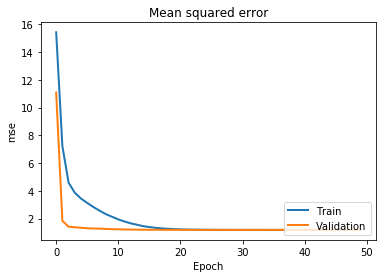

In [51]:
import matplotlib.pyplot as plt
import os
plt.plot(history['mean_squared_error'], linewidth=2, label='Train')
plt.plot(history['val_mean_squared_error'], linewidth=2, label='Validation')
plt.legend(loc='lower right')
plt.title('Mean squared error')
plt.ylabel('mse')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [52]:
sqrt(mean_squared_error(y_train, model.predict(X_train)))

1.089780356057323

In [53]:
sqrt(mean_squared_error(y_test, model.predict(X_test)))

1.091030490937479

## XGBoost Model

### Hyperparameter tuning

In [ ]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
xgb_model = XGBRegressor()

param_grid = {'n_estimators':np.arange(25,155,10),'max_depth':np.arange(3,18,3),'min_child_weight':np.arange(2,20,2), 'learning_rate':np.arange(0.0001,1, 0.0001),
              'gamma':np.arange(0.1,0.5,0.01),
             'subsample':np.arange(0.5,1.0,0.1)}
 
xgb_model_cv_grid = RandomizedSearchCV(estimator = xgb_model, param_distributions = param_grid, cv = 5, n_iter=100)
xgb_model_cv_grid.fit(X_train, y_train)
xgb_model_cv_grid.best_estimator_

### XGB - Final

In [0]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, importance_type='gain',
       learning_rate=0.1917, max_delta_step=0, max_depth=6,
       min_child_weight=6, missing=None, n_estimators=125, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.5)

In [145]:
model6 = xgb.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [0]:
train_pred7 = model6.predict(X_train)

In [0]:
test_pred7 = model6.predict(X_test)

In [148]:
sqrt(mean_squared_error(y_train, train_pred7))

0.9773211230180805

In [149]:
sqrt(mean_squared_error(y_test, test_pred7))

1.025405728087289

In [0]:
test_pred8 = pd.DataFrame({"reservation_id":test_temp['reservation_id'],"amount_spent_per_room_night_scaled":model6.predict(test)})